# McDonalds and other metrics
In this section we are going to scrape and analyze the data coming from the website https://eu.usatoday.com/story/money/business/2018/09/13/mcdonalds-states-most-stores/37748287/.

It is an article of the journal USA Today (one of the three more read journals in the US, with The Wall Street Journal and The New York Times [1]).

It shows some important statistics like the adult obesity rate, the percentage of people consuming vegetables less than daily, the median income and the number of McDonalds per capita. The article explains how difficult is it to find a correlation among the number of fast food per capita, and the unhealthy lifestyle (obesity rate), but still, for our purpose it may turn out to be an important factor along the other more important statistics, so at the moment we may want to keep this information and decide later to discard it.

The choice to use the chain McDonalds to estimate the HDI is not new [2]: it was shown how countries where the price of a Big Mac tend to be higher usually are the ones with the higher standard of quality.

We may therefore try to assume that the places with the least number of McDonalds tend to be the ones in which people live better. But it has to be said that this assumption is totally unfounded, and needs to be further verified. (This can be done, for instance, seeing if there is any sort of correlation among the number of Mc Donalds and the actual HDI index of States).

In [2]:
from requests import get
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import re
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup

In [3]:
# We start by getting the list of states in the United States
states_json = pd.read_json('Data/states.json')
states = []

for row in states_json['data']:
    states.append(row['State'])
    
# We create a DataFrame with states (it will come handy when looking for missing values).
states_df = pd.DataFrame({"State": states})
states_df.head()

,State
0,Alabama
1,Alaska
2,Arizona
3,Arkansas
4,California


# Scraping of data
We start our analysis by scraping the results from Usa Today's website.
We notice that the page shows a certain regularity, with the name of each coutry listed in a `<h3>` tag, followed by the information about that country. The information is enclosed in `<strong>` brackets: 
- first information: number of McDonald's per 100k inhabitants.
- second information: adult obesity percentage rate
- third information: people consuming vegetables less than daily (percentage)

In [4]:
# Get the page and scrape it with BeautifulSoup
usa_today_page = get('https://eu.usatoday.com/story/money/business/2018/09/13/mcdonalds-states-most-stores/37748287/')
usa_today_page = BeautifulSoup(usa_today_page.text, 'html.parser')

# find all h3 tags (they contain the name of the state)
titles = usa_today_page.find_all('h3', class_='presto-h3')

stats = []
for title in tqdm(titles):
    # Skip None rows (they are advertisement or bad formatted rows).
    if type(title) != 'NoneType' and re.findall("\d+\. [A-Z]", title.text):
        state = title.text
        # state is in format: number. name of state
        # Therefore we split by whitexpace, and keep from the second element on.
        state = " ".join(state.split(" ")[1:])
        p = title.find_next_sibling('p')
        # This while is used to skip random content found between 
        # the title <h3> ad the content <p>, like ad and so on.
        while(not p.text):
            p = p.find_next_sibling('p')
        
        points = p.text.split("•")
        
        try:
            # use regex to estrapolate the numbers we need
            mc_donalds_per_100k_inhabitants = re.findall("\d+.\d+", points[1])[0]
            adult_obesity_rate = re.findall("\d+.\d+", points[2])[0]
            vegetables = re.findall("\d+.\d+", points[3])[0]
            median_income = re.findall("\$\d+,\d+", points[4])[0]
            stat = {
                "State": state,
                "mc_donalds_per_100k": mc_donalds_per_100k_inhabitants,
                "adult_obesity_rate": adult_obesity_rate,
                "eating_vegetables_daily": vegetables,
                "median_income": median_income
            }

            stats.append(stat)
        except:
            # There are still some emtpy/not well formatted lines in the page, just skip them
            pass        

In [5]:
mc_donalds_df = pd.DataFrame(stats)  # Create DataFrame
print(mc_donalds_df.dtypes)   # Print types of rows (objects are strings)
mc_donalds_df.head() 

State                      object
mc_donalds_per_100k        object
adult_obesity_rate         object
eating_vegetables_daily    object
median_income              object
dtype: object


,State,mc_donalds_per_100k,adult_obesity_rate,eating_vegetables_daily,median_income
0,Rhode Island,2.9,27.2,23.5,"$60,596"
1,New Jersey,3.0,25.9,22.1,"$76,126"
2,New York,3.1,25.0,22.4,"$62,909"
3,California,3.3,22.7,18.6,"$67,739"
4,North Dakota,3.3,31.8,27.5,"$60,656"


## Data cleaning
We can see that all columns are listed as strings. Therefore we proceed to clean it.

In [6]:
mc_donalds_df.mc_donalds_per_100k = mc_donalds_df['mc_donalds_per_100k'].apply(lambda x: float(x))  # Cast to float
mc_donalds_df.adult_obesity_rate = mc_donalds_df['adult_obesity_rate'].apply(lambda x: float(x))   # Cast to float
mc_donalds_df.eating_vegetables_daily = mc_donalds_df['eating_vegetables_daily'].apply(lambda x: float(x))   # Cast to float
mc_donalds_df.median_income = mc_donalds_df['median_income'].apply(lambda x: float("".join(x.split("$")[1].split(","))))  # Remove $ sign and comma, and cast to float

In [7]:
print(mc_donalds_df.dtypes)  # Types should be correct now!
mc_donalds_df.head()

State                       object
mc_donalds_per_100k        float64
adult_obesity_rate         float64
eating_vegetables_daily    float64
median_income              float64
dtype: object


,State,mc_donalds_per_100k,adult_obesity_rate,eating_vegetables_daily,median_income
0,Rhode Island,2.9,27.2,23.5,60596.0
1,New Jersey,3.0,25.9,22.1,76126.0
2,New York,3.1,25.0,22.4,62909.0
3,California,3.3,22.7,18.6,67739.0
4,North Dakota,3.3,31.8,27.5,60656.0


# Analysis of completeness:
We merge the data into the dataframe of states, and check whether there are any null values (to check if any state is not represented in out statistics).

In [8]:
# We perform a left join, so that missing values will have the right columns set as null
mc_donalds_state_df = states_df.merge(mc_donalds_df, how='left', left_on='State', right_on="State")
mc_donalds_state_df.head()

,State,mc_donalds_per_100k,adult_obesity_rate,eating_vegetables_daily,median_income
0,Alabama,5.0,34.7,27.8,46257.0
1,Alaska,4.2,29.4,18.9,76440.0
2,Arizona,4.1,26.7,20.5,53558.0
3,Arkansas,5.8,34.6,28.1,44334.0
4,California,3.3,22.7,18.6,67739.0


In [9]:
# We check for missing values in any column (the ones merged before, where no information
# for the state was found)
mc_donalds_state_df[mc_donalds_state_df.isna().any(axis=1)]

,State,mc_donalds_per_100k,adult_obesity_rate,eating_vegetables_daily,median_income
8,District of Columbia,NaN,NaN,NaN,NaN


We can clearly see that the District of Columbia is not listed in the website.
Therefore, we need to find the information somewhere else:

### Number of McDonalds:
According to the website https://foursquare.com/locations/mcdonalds/washington-dc, there are 84 McDonalds shop in the city of Washington DC. Among them, only 31 are actually in the District of Columbia. (Counted manually)

The population of the District of Columbia is 702,445 [3]

This allows us to see that the number of McDonalds every 100k inhabitants is: 

31 / (702445 / 100000) = 4.4

### Median Income
$82,372 according to [4]

### Adult obesity rate
24.7% according to [5]

### People eating vegetables daily
In order to find this missin figure, further effort must be spent. We didn't manage, in fact, to find this figure online, therefore we had to make an estimation for it: first, we found a report made by the Centre for Disease Prevention and Control [6] which lists the median intake frequency of vegetables in all US states. 
If we can show that this data is highly correlated with the figure we are looking for, we can estimate the missing value using the values of the new table.

In [10]:
# Get and parse the page with requests and BeautifulSoup
cdc_page = get('https://www.cdc.gov/mmwr/volumes/66/wr/mm6645a1.htm?s_cid=mm6645a1_w&utm_source=STAT+Newsletters&utm_campaign=f26644060f-MR&utm_medium=email&utm_term=0_8cab1d7961-f26644060f-150444909')
cdc_page = BeautifulSoup(cdc_page.text, 'html.parser')

# Find the first table (it's the one with the information we need)
table = cdc_page.find_all('table')[0] 

# Use pandas function read_html, which automagically parses an html table into a well formatted DataFrame
table_scraped = pd.read_html(str(table))

table_df = table_scraped[0][1:]   # Skip the first row which is garbage

states = table_df['Jurisdiction']
vegetables = table_df['Median daily intake frequency']['Vegetable']

# We merge the state name and the median daily intake frequency of vegetable into our dataframe
states_vegetables = states.merge(vegetables, left_index=True, right_index=True)

print(states_vegetables.dtypes)
states_vegetables.head()

Jurisdiction     object
Vegetable       float64
dtype: object


,Jurisdiction,Vegetable
1,Alabama,1.5
2,Alaska,1.8
3,Arizona,1.7
4,Arkansas,1.5
5,California,1.8


We can now merge the new table into the old table, and see the correlation ratio. 

In [11]:
# We merge the two datasets (right on states_vegetables, as it has no missing values)
mc_donalds_state_vegetable_df = mc_donalds_state_df.merge(states_vegetables, right_on='Jurisdiction', left_on='State').drop('Jurisdiction', axis=1)
mc_donalds_state_vegetable_df.head()

,State,mc_donalds_per_100k,adult_obesity_rate,eating_vegetables_daily,median_income,Vegetable
0,Alabama,5.0,34.7,27.8,46257.0,1.5
1,Alaska,4.2,29.4,18.9,76440.0,1.8
2,Arizona,4.1,26.7,20.5,53558.0,1.7
3,Arkansas,5.8,34.6,28.1,44334.0,1.5
4,California,3.3,22.7,18.6,67739.0,1.8


In [12]:
# We finally compute the correlation ratio
corr = mc_donalds_state_vegetable_df.eating_vegetables_daily.corr(mc_donalds_state_vegetable_df.Vegetable)
print("The correlation among the two vegetable indicators is {}".format(corr))

The correlation among the two vegetable indicators is -0.9470000686362137


We can clearly see that the correlation (negative) is very high. We plot the scatterplot for further safety:

Text(0.5, 0, 'Percentage of people not eating vegetables daily')

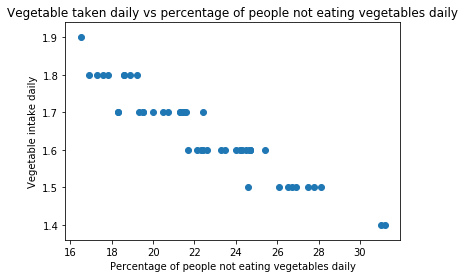

In [13]:
plt.scatter(mc_donalds_state_vegetable_df.eating_vegetables_daily, mc_donalds_state_vegetable_df.Vegetable)
plt.title("Vegetable taken daily vs percentage of people not eating vegetables daily")
plt.ylabel("Vegetable intake daily")
plt.xlabel("Percentage of people not eating vegetables daily")

In [14]:
# We select the District of Columbia one, to see with which value we can substitute it.
dc_vegetable = mc_donalds_state_vegetable_df.loc[mc_donalds_state_vegetable_df.State == 'District of Columbia', 'Vegetable']

dc_vegetable = next(iter(dc_vegetable), "No DC Found")

print("The value of Vegetable median intake frequency for District of Columbia is: {}".format(dc_vegetable))

print("the other similar countries are: ")
mc_donalds_state_vegetable_df.loc[mc_donalds_state_vegetable_df.Vegetable == dc_vegetable, ['State', 'Vegetable']]

The value of Vegetable median intake frequency for District of Columbia is: 1.9
the other similar countries are: 


,State,Vegetable
8,District of Columbia,1.9
37,Oregon,1.9


Therefore, we can conclude that the missing value for the average of people not eating vegetable daily in the District of Columbia should be very small: it may be assumed to be similar to the one of Oregon (actually they top together the standing).

In [15]:
# We can finally create the District of Columbia cell

# we select the value for people eating vegetable daily in Oregon, it will be the value we use in DC
eating_veg_daily_oregon = next(iter(mc_donalds_state_vegetable_df.loc[mc_donalds_state_vegetable_df.State == 'Oregon', 'eating_vegetables_daily']))
new_df = pd.DataFrame([{
    'State': 'District of Columbia',  # Name
    'mc_donalds_per_100k': 4.4,   # Taken from the web
    'adult_obesity_rate': 24.7,   # Taken from the web 
    'eating_vegetables_daily': eating_veg_daily_oregon,   # Estimated in the above cells
    'median_income': 82372,   # Taken from the web
    'Vegetable': dc_vegetable   # taken from the gov dataset
}])

# Substitute the District of Columbia cell
df_no_dc = mc_donalds_state_vegetable_df[mc_donalds_state_vegetable_df.State != "District of Columbia"]  
df = pd.concat([df_no_dc, new_df], axis = 0)

In [16]:
df.head()

,State,mc_donalds_per_100k,adult_obesity_rate,eating_vegetables_daily,median_income,Vegetable
0,Alabama,5.0,34.7,27.8,46257.0,1.5
1,Alaska,4.2,29.4,18.9,76440.0,1.8
2,Arizona,4.1,26.7,20.5,53558.0,1.7
3,Arkansas,5.8,34.6,28.1,44334.0,1.5
4,California,3.3,22.7,18.6,67739.0,1.8


We can further verify that our substitution was successful:

In [17]:
df[df.isna().any(axis=1)]

,State,mc_donalds_per_100k,adult_obesity_rate,eating_vegetables_daily,median_income,Vegetable


In [18]:
df = df.sort_values(by=['State'], ascending=True).reset_index()  # We sort again by state name
df.head()

,index,State,mc_donalds_per_100k,adult_obesity_rate,eating_vegetables_daily,median_income,Vegetable
0,0,Alabama,5.0,34.7,27.8,46257.0,1.5
1,1,Alaska,4.2,29.4,18.9,76440.0,1.8
2,2,Arizona,4.1,26.7,20.5,53558.0,1.7
3,3,Arkansas,5.8,34.6,28.1,44334.0,1.5
4,4,California,3.3,22.7,18.6,67739.0,1.8


## Save Pickle
Before doing the analysis, we save the DataFrame in a pickle file, so that we can merge all datasets later in `Milestone2.ipynb` notebook 

In [19]:
df.to_pickle("Pickles/mc_donalds.pickle")

# Analysis
We can perform now some statistics to see if there are any outliers

Text(0, 0.5, 'Number of mc Donalds (every 100k inhabitabts)')

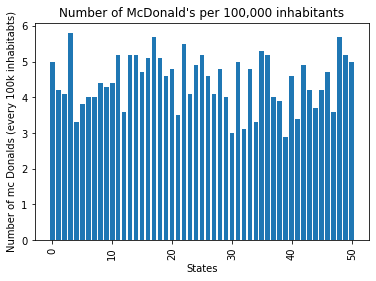

In [20]:
plt.xticks(rotation=90)   # Rotate x labels, otherwise they would become intellegible.
plt.title("Number of McDonald's per 100,000 inhabitants")
plt.bar(df.index, df.mc_donalds_per_100k)
plt.xlabel("States")
plt.ylabel("Number of mc Donalds (every 100k inhabitabts)")

<BarContainer object of 51 artists>

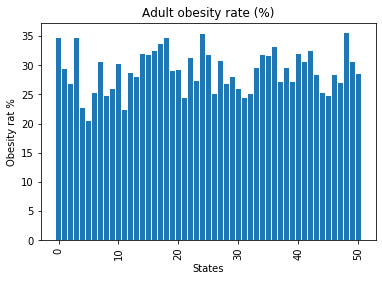

In [21]:
plt.xticks(rotation=90)
plt.title("Adult obesity rate (%)")
plt.xlabel("States")
plt.ylabel("Obesity rat %")
plt.bar(df.index, df.adult_obesity_rate)

<BarContainer object of 51 artists>

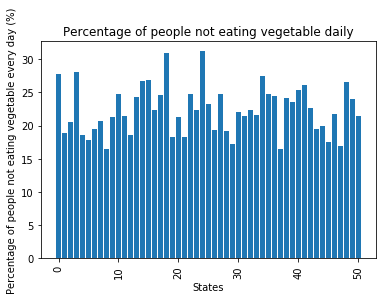

In [22]:
plt.xticks(rotation=90)
plt.title("Percentage of people not eating vegetable daily")
plt.xlabel("States")
plt.ylabel("Percentage of people not eating vegetable every day (%)")
plt.bar(df.index, df.eating_vegetables_daily)

<BarContainer object of 51 artists>

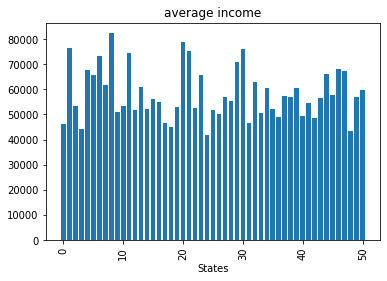

In [23]:
plt.xticks(rotation=90)
plt.title("average income")
plt.xlabel("States")
plt.ylabel("")
plt.bar(df.index, df.median_income)

We can see that fortunately there are no outliers. Therefore we can try to understand if there are some values which may influence each other.

In [24]:
df.corr()

,index,mc_donalds_per_100k,adult_obesity_rate,eating_vegetables_daily,median_income,Vegetable
index,1.000000,-0.063636,0.099316,0.023291,-0.148000,-0.079214
mc_donalds_per_100k,-0.063636,1.000000,0.548133,0.415053,-0.502974,-0.386006
adult_obesity_rate,0.099316,0.548133,1.000000,0.766348,-0.633028,-0.746858
eating_vegetables_daily,0.023291,0.415053,0.766348,1.000000,-0.582964,-0.947860
median_income,-0.148000,-0.502974,-0.633028,-0.582964,1.000000,0.546742
Vegetable,-0.079214,-0.386006,-0.746858,-0.947860,0.546742,1.000000


Very interestingly (actually the article [1] has already pointed it out) there is no particular correlation among the McDonald's distribution of restaurants and the obesity rate. But this observation actually is outside the scope of this analysis.

Another correlation we may be interested is the one among the median income, and the adult obesity rate: in fact, there is a slight negative correlation (-0.63) among the two figures.

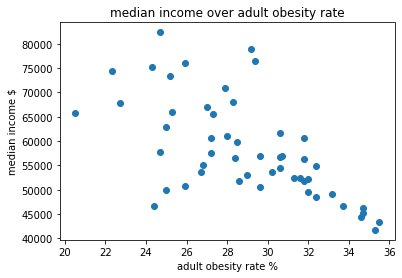

In [25]:
plt.title("median income over adult obesity rate")
plt.xlabel("adult obesity rate %")
plt.ylabel("median income $")
plt.scatter(df.adult_obesity_rate, df.median_income)

We can see that for "low" levels of obesity (below 30%), there is no correlation at all, instead for very high levels of obesity (over 30%) the two figures are clearly linearly dependent (the higher the obesity rate, the lower the median income).


- [1] https://en.wikipedia.org/wiki/USA_Today
- [2] https://en.wikipedia.org/wiki/Big_Mac_Index
- [3] https://en.wikipedia.org/wiki/Washington,_D.C only the population of the federal city
- [4] https://datausa.io/profile/geo/washington-dc/
- [5] https://stateofchildhoodobesity.org/states/dc/
- [6] https://www.cdc.gov/mmwr/volumes/66/wr/mm6645a1.htm?s_cid=mm6645a1_w&utm_source=STAT+Newsletters&utm_campaign=f26644060f-MR&utm_medium=email&utm_term=0_8cab1d7961-f26644060f-150444909